In [1]:
from __future__ import division, print_function
from importlib import reload

In [2]:
import abstention
reload(abstention)
reload(abstention.calibration)
reload(abstention.label_shift)
from abstention.calibration import TempScaling, ConfusionMatrix, softmax
from abstention.label_shift import EMImbalanceAdapter, BBSEImbalanceAdapter, ShiftWeightFromImbalanceAdapter
import glob
import gzip
import json
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
loaded_dicts = json.loads(gzip.open("label_shift_adaptation_results.json.gz").read())
metric_to_samplesize_to_calibname_to_unshiftedvals =\
    loaded_dicts['metric_to_samplesize_to_calibname_to_unshiftedvals']

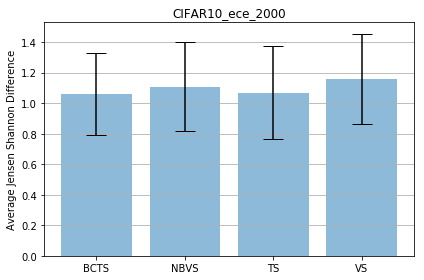

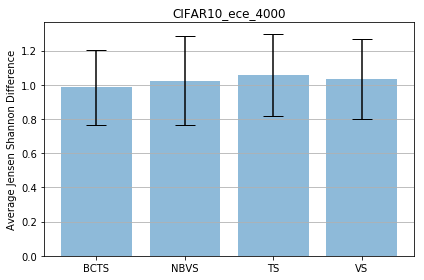

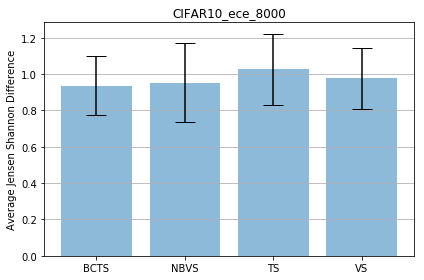

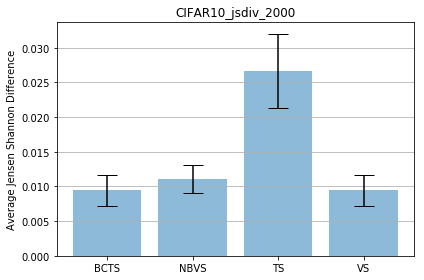

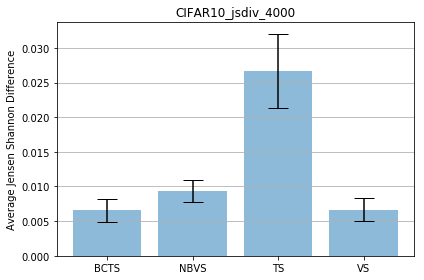

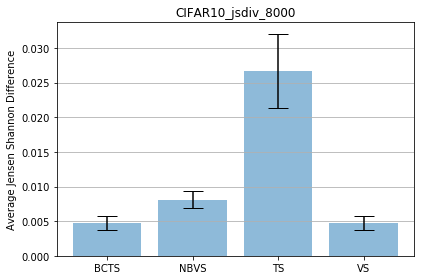

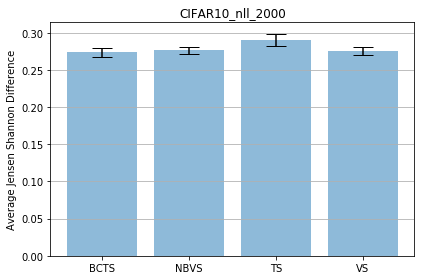

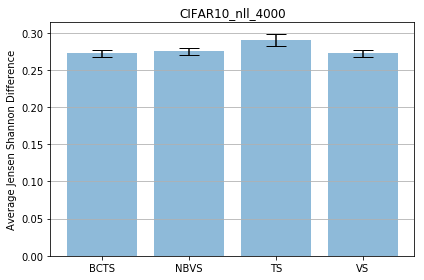

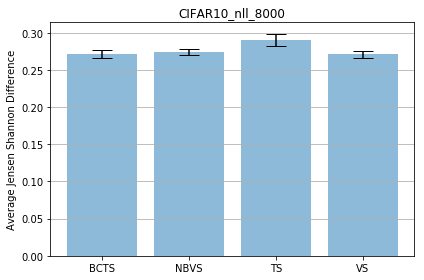

In [4]:
x = np.arange(4)
methods = ['BCTS', 'NBVS', 'TS', 'VS']

for metric in metric_to_samplesize_to_calibname_to_unshiftedvals:
    for size in metric_to_samplesize_to_calibname_to_unshiftedvals[metric]:
        y = [np.mean(np.array(metric_to_samplesize_to_calibname_to_unshiftedvals[metric][size][method])) for method in methods]
        error = [np.std(np.array(metric_to_samplesize_to_calibname_to_unshiftedvals[metric][size][method])) for method in methods]
        fig, ax = plt.subplots()

        ax.bar(x, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
        ax.set_ylabel('Average Jensen Shannon Difference')
        ax.set_xticks(x)
        ax.set_xticklabels(methods)
        ax.set_title('CIFAR10_'+metric+'_'+size)
        ax.yaxis.grid(True)
        plt.tight_layout()
        plt.show()